In [2]:
import numpy as np
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.model_selection import KFold
from sklearn import preprocessing
from timerun import time_code, time_func
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the madelon training dataset
train_data = pd.read_table("MADELON/madelon_train.data", sep=' ', header=None, usecols=range(0,500))
train_labels = pd.read_table("MADELON/madelon_train.labels", sep=' ', header=None)
X_train, X_test = np.split(preprocessing.scale(train_data.to_numpy()), [1600])
y_train, y_test = np.split(np.ravel(train_labels.to_numpy()), [1600])

In [3]:
import random
def randomSelection(CVal):
    random_scores_train = {}
    random_scores_test = {}
    random_selection = random.sample(range(0, 500), 500)
    for i in range(1, 500, 2):
        features = random_selection[:i]
    
        svm = LinearSVC(C=CVal, max_iter=2000, dual=False)
        svm.fit(X_train[:,features], y_train)

        random_scores_train[i] = svm.score(X_train[:,features], y_train)
        random_scores_test[i] = svm.score(X_test[:,features], y_test)
    return random_scores_train, random_scores_test

def kfold(X, y, k):
    n = int(X.shape[0]/k)
    Xfolds = np.split(X, list(range(n, n*k, n)))
    yfolds = np.split(y, list(range(n, n*k, n)))

    folds = []
    for i in range(k):
        XT = np.concatenate(Xfolds[:i] + Xfolds[i+1:])
        yT = np.concatenate(yfolds[:i] + yfolds[i+1:])
        Xt = Xfolds[i]
        yt = yfolds[i]
        folds += [(XT, yT, Xt, yt)]

    return folds

scores = []
for i in range(0,3):
    fold_scores = []
    CVal = 10**i
    for XT, yT, Xt, yt in kfold(X_train, y_train, 4):
        svm = LinearSVC(C=CVal, max_iter=2000, dual=False)    
        svm.fit(XT, yT)
        fold_scores += [svm.score(Xt, yt)]
        print(CVal, fold_scores)
    scores += [[np.mean(fold_scores), np.var(fold_scores)]]
    print(scores)

1 [0.49]
1 [0.49, 0.54]
1 [0.49, 0.54, 0.5125]
1 [0.49, 0.54, 0.5125, 0.585]
[[0.531875, 0.0012542968749999998]]
10 [0.495]
10 [0.495, 0.54]
10 [0.495, 0.54, 0.5125]
10 [0.495, 0.54, 0.5125, 0.58]
[[0.531875, 0.0012542968749999998], [0.531875, 0.0010292968749999996]]
100 [0.5]
100 [0.5, 0.54]
100 [0.5, 0.54, 0.51]
100 [0.5, 0.54, 0.51, 0.58]
[[0.531875, 0.0012542968749999998], [0.531875, 0.0010292968749999996], [0.5325, 0.0009687499999999991]]


In [4]:
len(list(range(-100, 400, 5)))

100

In [5]:
scores = {}
kf = KFold(n_splits=10, shuffle=True)
for i in range(-100, 400, 5):
    fold_scores = []
    CVal = 10**(i/100)
    with time_code('CVAL ' + str(CVal)):
        for train_index, test_index in kf.split(X_train):
            XT, Xt = X_train[train_index], X_train[test_index]
            yT, yt = y_train[train_index], y_train[test_index]

            svm = LinearSVC(C=CVal, max_iter=2000, dual=False)    
            svm.fit(XT, yT)
            fold_scores += [svm.score(Xt, yt)]
    scores[CVal] = np.mean(fold_scores), np.var(fold_scores)
    print(CVal, scores[CVal])

CVAL 0.1 - 00:00:01.476012000
0.1 (0.516875, 0.002062890625)
CVAL 0.11220184543019636 - 00:00:01.448555900
0.11220184543019636 (0.5262500000000001, 0.0012953125000000009)
CVAL 0.12589254117941673 - 00:00:01.586111000
0.12589254117941673 (0.505625, 0.0020269531250000014)
CVAL 0.14125375446227545 - 00:00:01.609765100
0.14125375446227545 (0.519375, 0.0018238281249999995)
CVAL 0.15848931924611134 - 00:00:01.639433700
0.15848931924611134 (0.5237499999999999, 0.0024359374999999997)
CVAL 0.1778279410038923 - 00:00:01.672259800
0.1778279410038923 (0.50375, 0.000509375)
CVAL 0.19952623149688797 - 00:00:01.658931900
0.19952623149688797 (0.51875, 0.0009999999999999996)
CVAL 0.22387211385683395 - 00:00:01.757697900
0.22387211385683395 (0.520625, 0.0006332031250000003)
CVAL 0.251188643150958 - 00:00:01.755392800
0.251188643150958 (0.521875, 0.0012050781250000006)
CVAL 0.28183829312644537 - 00:00:01.675003100
0.28183829312644537 (0.52125, 0.0012046874999999998)
CVAL 0.31622776601683794 - 00:00:01.76

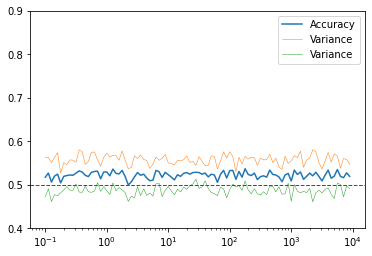

In [6]:
plt.plot(scores.keys(), [x for x, y in scores.values()], label = "Accuracy")
plt.plot(scores.keys(), [x + y**(0.5) for x, y in scores.values()], label = "Variance", linewidth=0.5)
plt.plot(scores.keys(), [x - y**(0.5) for x, y in scores.values()], label = "Variance", linewidth=0.5)
plt.legend()
plt.ylim([0.4,0.9])
plt.xscale('log')
plt.axhline(0.5, color = "red", linewidth=1, linestyle="--")
plt.show()

# Try CV on RFE

In [7]:
from multiprocessing import Pool
from parallel_methods import DSMethods
from timerun import time_code, time_func
import time
from sklearn.model_selection import KFold

In [8]:
def plot_train_vs_test(train_scores, test_scores, points = {}, time = -1):
    if points != {}: plt.scatter(points.keys(), points.values(), marker='|', zorder = 3)
    plt.plot(train_scores.keys(), train_scores.values(), label = "Train", zorder = 2)
    plt.plot(test_scores.keys(), test_scores.values(), label = "Test", zorder = 1)
    plt.legend()
    plt.ylim([0.4,1.0])
    plt.axhline(0.5, color = "red", linewidth=1, linestyle="--")
    plt.show()

    maxarg = list(test_scores.keys())[np.argmax(list(test_scores.values()))]
    print("AT", maxarg, test_scores[maxarg], "WITH", len(points), "ITERATIONS IN", time, "SECONDS")

def mean_of_arrays(data):
    arr = {}
    for x in data[0]:
        arr[x] = np.mean([data[v][x] for v in data])
    return arr

In [9]:
def SVM_RFE_W_DSTEP_PLOT(percentage, stop=1):
    kf = KFold(n_splits=20, shuffle=True)

    index = [(test_index, train_index, percentage, stop) for test_index, train_index in kf.split(data.X_train)]
    with Pool(7) as pool:
        scores = pool.map(data.svm_rfe_dynamic_step_only, index)
        scores= list(scores)

    # result = list(map(data.svm_rfe_dynamic_step_only, index))

    train_scores = mean_of_arrays({i: x[0] for i, x in enumerate(scores)})
    test_scores  = mean_of_arrays({i: x[1] for i, x in enumerate(scores)})
    points       = mean_of_arrays({i: x[2] for i, x in enumerate(scores)})
    time         = np.mean([x[3] for x in scores])

    maxarg = list(test_scores.keys())[np.argmax(list(test_scores.values()))]
    return test_scores[maxarg]

In [ ]:
SVM_RFE_W_DSTEP_PLOT(0.3)

In [ ]:
scores = {}
kf = KFold(n_splits=10, shuffle=True)
for i in range(-100, 400, 5):
    fold_scores = []
    CVal = 10**(i/100)
    with time_code('CVAL ' + str(CVal)):
        for train_index, test_index in kf.split(X_train):
            XT, Xt = X_train[train_index], X_train[test_index]
            yT, yt = y_train[train_index], y_train[test_index]

            svm = LinearSVC(C=CVal, max_iter=2000, dual=False)    
            svm.fit(XT, yT)
            fold_scores += [svm.score(Xt, yt)]
    scores[CVal] = np.mean(fold_scores), np.var(fold_scores)
    print(CVal, scores[CVal])